# Combinando piezas para construir un sintetizador

- Hemos visto cómo construir generadores de señal:

    - Osciladores simples (síntesis aditiva)


- Hemos visto (por encima) cómo funcionan las envolventes

- Podemos *reproducir partituras* con osciladores

- Ahora vamos a combinar piezas

# Generadores de señal, hebras de ejecución... y TKInter 

Vamos a combinar ideas que hemos visto e integrarlas con TKInter para construir un modelo de procesamiento de señal:

- TKInter

    - Modelo sencillo y potente para construir GUIs
        
        - Ventanas con widgets 

        - Y **lectura no bloqueante** de teclado

    - Ejecución en una hebra: el bucle ppal de la aplicación será el propio de TKInter

- SoundDevice con reproducción (y grabación) con **CallBacks**

    - Distinta hebra de ejecución: nos ocupamos de rellenar el flujo de señal (sin bucle explícito)

In [4]:
#%% librerías y constantes necesarias
import numpy as np         
import sounddevice as sd       
import matplotlib.pyplot as plt
from tkinter import *

SRATE, CHUNK = 48000, 1024

# Generadores de señal: iteradores

Todas las señales se generan mediante objetos que tienen:

- Constructora para inicializar el generador (frecuencia, amplitud, etc)

- Método **next** para devolver el *siguiente chunk* de señal: 

El propio generador debe garantizar la continuidad de la señal producida (tiene memoria del último frame generado)

In [5]:
#%% el oscilador sinusoidal como generador de señal
class Osc:
    def __init__(self,freq=440.0,amp=1.0,phase=0.0):
        self.freq = freq
        self.amp = amp
        self.phase = phase
        self.frame = 0

    def next(self):    
        out = self.amp*np.sin(2*np.pi*(np.arange(self.frame,self.frame+CHUNK))*self.freq/SRATE)
        self.frame += CHUNK
        return out

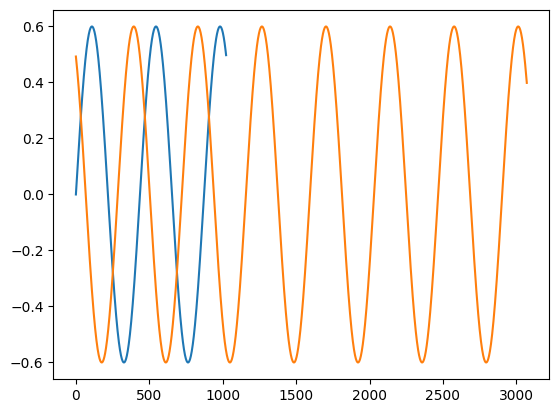

In [6]:
nota = Osc(110.0,0.6,0.0)
bloque = nota.next()

# un chunk
plt.plot(bloque)

varios = np.zeros(0)
for i in range(3):
    varios = np.append(varios,nota.next())

plt.plot(varios)


In [7]:
#%% una envolvente sencilla
class Env:
    def __init__(self,attack=0.1,release=0.9,amp=0.8):
        self.env = np.concatenate((np.linspace(0,amp,int(attack*SRATE)),np.linspace(amp,0,int(release*SRATE))))
        self.frame = 0

    def next(self):
        if self.frame >= len(self.env):
            return None
        else:
            out = self.env[self.frame:self.frame+CHUNK]
            out = np.pad(out,(0,CHUNK-len(out)),'constant')
            self.frame += CHUNK
            return out


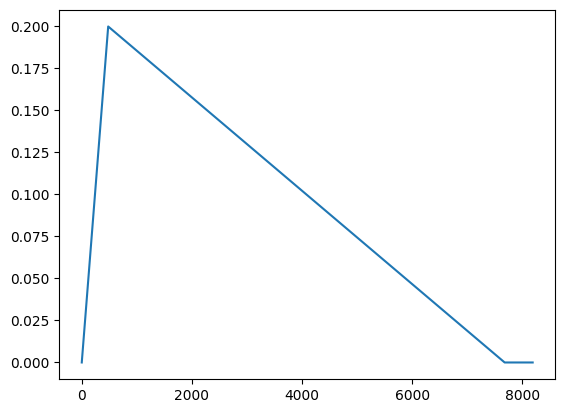

In [8]:
env = Env(attack=0.01, release=0.15, amp=0.2)


varios = np.zeros(0)
for i in range(12):
    varios = np.append(varios,env.next())

plt.plot(varios)

# Combinando señales: oscilador con envolvente = nota

In [9]:
class Note:
    def __init__(self,freq=440.0,attack=0.1,release=0.9,amp=0.8):
        self.osc = Osc(freq)
        self.env = Env(attack,release,amp)

    def next(self):
        env = self.env.next()
        if env is None:
            return None
        return self.osc.next()*env

# Enrutando la señal

Utilizamos sounddevice con call back

- Recoge los chunk de una variable global **input** que debe ser una señal!

    - Debe tener un método next tal como se ha explicado

- Cuando se cree un generador tiene que *conectarse* a este input para escuchar el resultado

TODO el procesamiento se hace por bloques

In [10]:
# stream de salida con callBack
input = None
def callback(outdata, frames, time, status):
    if status: print(status)
    if input:    
        s = input.next()
        s = np.float32(s)
    else:
        s = np.zeros(CHUNK,dtype=np.float32)
    outdata[:] = s.reshape(-1, 1)

# stream de salida con callBack
stream = sd.OutputStream(samplerate=SRATE, callback=callback, blocksize=CHUNK)
stream.start()


# TKInter + enrutado de señal del generador

In [11]:

# inicialización de la ventanas 
root=Tk()

# Caja de texto
text = Text(root,height=6,width=60)
text.pack(side=BOTTOM)
text.insert(INSERT,"Press 'a' to activate note and 'space' to deactivate\n")

# call back para la pulsación de teclas
def key_down(event):
    global input  # conexión con sounddevice
    if event.char=='a': 
        print('note activated')
        input = Note(amp=0.6,release=2)  # enrutamos la señal de la nota al "input" del stream
    elif event.char==' ': 
        print('note deactivated')
        input = None

# enlace de la pulsación de teclas con la función key_down
text.bind('<Key>', key_down)


# arrancamos todo!!
root.mainloop()
# ejecución bloqueada hasta que se cierre ventana

# limpieza..
stream.stop()
stream.close()

output underflow
output underflow


# Constantes de trabajo

Además de la frecuencia de muestreo el tamaño del CHUNK definimos

- Mapeo de teclas del ordenador a notas... para poder lanzad notas con el teclado

- Frecuencias asociadas a estas notas: utilizamos una conocida fórmula para construir la escala temperada

- Frecuencias asociadas a las notas midi: referencia 60 es c ("do"), 61 es C#, 62 D... 59 B, 58 A#


In [12]:
%%writefile consts.py

# para todo el proyecto (no cambian)
SRATE = 48000 # frecuencia de muestreo
CHUNK = 1024  # tamaño de los CHUNKs

# mapeo de teclas del ordenador a notas en el piano
# utilizamos '.' para los sostenidos
teclas = "zsxdcvgbhnjmq2w3er5t6y7u"  # 2 de teclas filas 
notas =  "C.D.EF.G.A.Bc.d.ef.g.a.b"  # mapeadas a 2 octavas
#         octava baja||octava alta


# frecuencias de las notas asocidas a las teclas del teclado
# partimos del la=220Hz y generamos frecuencias de escala temperada
pitchs = [ 220*2.0**(i/12.0) for i in range(len(teclas))] 

# frecuencias asociadas a las notas midi de 0 a 127
# El LA central es la nota midi 70 y su frecuencia es 440
# contruimos hacia abajo y hacia arriba el resto de notas
freqsMidi = [ 440*2.0**(i/12.0) for i in range(-69,59)]


Overwriting consts.py


In [13]:
%load_ext autoreload
%autoreload 2
# para recargar módulos en cada ejecución

from consts import *

# así, la tecla 'n' del teclado corresponde a la nota...
index = teclas.index('n') # sacamos posición en el string notas
nota  = notas[index]      
print(nota)

print(p)


A


NameError: name 'p' is not defined

# Nuestro primer **generador de señal**: oscilador básico

- Incorpora el *frame* actual: número de sample (es equivalente a la fase)

- Todos los *generadores y modificadores* de señal incorporan método **next**

    - devuelve el siguiente chunk y actualiza el *frame*



In [ ]:
%%writefile osc.py

from consts import *
import numpy as np         
import sounddevice as sd       
import matplotlib.pyplot as plt

class Osc:
    def __init__(self,freq=440.0,amp=1.0,phase=0.0):
        self.freq = freq
        self.amp = amp
        self.phase = phase
        self.frame = 0

    def next(self):    
        out = self.amp*np.sin(2*np.pi*(np.arange(self.frame,self.frame+CHUNK))*self.freq/SRATE)
        self.frame += CHUNK
        return out

Overwriting osc.py


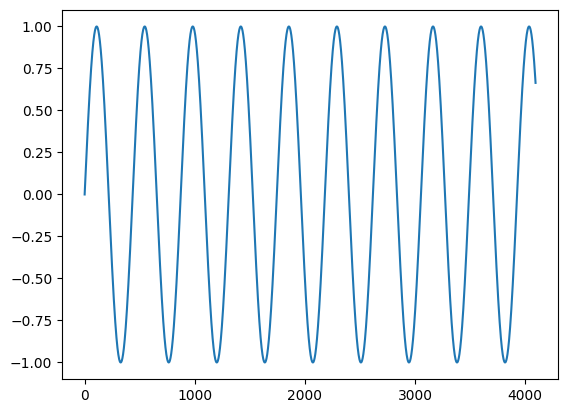

In [ ]:
# un ejemplo
from osc import *

# oscilador de 110 Hz
o = Osc(110)

# Concatemamos 4 chunks y dibujamos (4096 muestras)
sig = np.zeros(0)
for i in range(4):
    sig = np.concatenate((sig,o.next()))
plt.plot(sig)

# Otro generador: oscilador con frecuencia modulada (FM)

- Véase https://piqued.fm/an-in-depth-exploration-into-how-fm-synthesis-works/


In [ ]:
%%writefile oscFM.py

%load_ext autoreload
%autoreload 2

import numpy as np   
import osc
import matplotlib.pyplot as plt
from consts import *

class OscFM:
    def __init__(self,fc=110.0,amp=1.0,fm=6.0, beta=1.0):
        self.fc = fc
        self.amp = amp
        self.fm = fm
        self.beta = beta
        self.frame = 0

        # moduladora = βsin(2πfm)
        self.mod = osc.Osc(freq=fm,amp=beta)
        
    def next(self):  
        # sin(2πfc+mod)  
        # sacamos el siguiente chunk de la moduladora
        mod = self.mod.next()

        # soporte para el chunk de salida
        sample = np.arange(self.frame,self.frame+CHUNK)        
        # aplicamos formula
        out =  self.amp*np.sin(2*np.pi*self.fc*sample/SRATE + mod)
        self.frame += CHUNK
        return out 

    def setBeta(self,beta):
        self.beta = beta
        self.mod.amp = beta

    def setFm(self,fm):
        self.fm = fm
        self.mod.freq = fm

    def getBeta(self):
        return self.beta    

    def getFm(self):
        return self.fm

        

Overwriting oscFM.py


In [ ]:
%load_ext autoreload
%autoreload 2
from oscFM import *

# oscilador FM    
o = OscFM(fc=20,fm=1000,beta=0.1)

# concatenamos 3 chunks y dibujamos
sgn = np.zeros(0)
for i in range(3):
    sgn = np.concatenate((sgn,o.next()))
plt.plot(sgn)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


SyntaxError: invalid syntax (oscFM.py, line 2)

In [ ]:
# también podemos hacerlo sonar
from oscFM import *
import sounddevice as sd
# oscilador FM    
o = OscFM(amp=0.2,fc=220,fm=1000,beta=0.1)

# concatenamos 30 chunks y hacemos sonar 
# 
sgn = np.zeros(0)
for i in range(100): # 100*CHUNK = 102400; 102400/SRATE = 2.13 segundos
    sgn = np.concatenate((sgn,o.next()))

sd.play(sgn)

# Un experimento con FM

Vamos a variar dinámicamente la frecuencia de la moduladora y el coficiente beta

Dejamos fija la frecuencia fundamental y su amplitud

In [ ]:
from consts import *
import sounddevice as sd
from tkinter import *
from oscFM import *


def callback(outdata, frames, time, status):
    if status: print(status)
    if input:    
        s = input.next()
        s = np.float32(s)
    else:
        s = np.zeros(CHUNK,dtype=np.float32)
    outdata[:] = s.reshape(-1, 1)
stream = sd.OutputStream(samplerate=SRATE, callback=callback, blocksize=CHUNK)
stream.start()


o = OscFM(amp=0.2,fc=220,fm=1000,beta=0.1)
input = o

root=Tk()
text = Text(root,height=6,width=60)
text.pack(side=BOTTOM)
text.insert(INSERT,"Press [F/f] to modify the modulation freq, [B/b] beta\n")

# call back para la pulsación de teclas
def key_down(event):
    global o
    global input  # conexión con sounddevice
    if event.char=='F':         
        o.setFm(o.getFm()+10)
    elif event.char=='f': 
        o.setFm(o.getFm()-10)
    elif event.char=='B':        
        o.setBeta(o.getBeta()+0.1)
    elif event.char=='b':
        o.setBeta(o.getBeta()-0.1)
    text.insert(INSERT,f'fm: {o.getFm()}, beta: {o.getBeta()}\n') 

# enlace de la pulsación de teclas con la función key_down
text.bind('<Key>', key_down)

# arrancamos todo!!
root.mainloop()
# ejecución bloqueada hasta que se cierre ventana

# limpieza..
stream.stop()
stream.close()

# Inciso: contenido armónico en FM

Vamos a generar señal modulada, ajustar la frecuencia moduladora y el índice $\beta$... y ver el contenido armónico




In [ ]:
%run -i 'fmPyo.py'


# Envolventes: *esculpiendo* la forma de onda


Para simular una pulsación de cuerda o una nota de un instrumento de viento, además de utilizar un timbre adecuado, hay que *dar forma* a la señal.

- En algunos instrumentos: incremento rápido de amplitud que luego desciende gradualmente (cuerdas pulsadas/percutidas).

- En otros el incremento es gradual y luego puede sostenerse en un nivel más o menos constante (cuerda frotada, vientos...)

La forma de la envolvente es característica del instrumento y muy importante para modelarlo. Cómo es en una guitarra, una flauta, etc?

Modificar la amplitud de una señal $=$ multiplicar sus muestras por un valor dado

<br>


Una envolvente es una señal especial:

- No está previsto que suene: no es un generador propiamente dicho, no se reproduce como tal

- Pero incorpora el método **next()**

- para *dar forma* a otra señal



Definimos las envolventes como lista de $n$ puntos, pares $(tiempo,valor)$ 

$$
    points = [(t_0,v_0),(t_1,v_1),...,(t_{n-1},v_{n-1})]    
$$

(También admitirá listas $(sample,valor)$ -> al final convertimos siempre tiempo a Frame)

El *comportamiento pretendido* de la envolvente es: 

- da forma a la señal **hasta que termina**

- y después *continúa indefinidamente* con el último valor $v_{n-1}$ (salida constante)


In [ ]:
%%writefile env.py

import numpy as np   
import matplotlib.pyplot as plt
from consts import *

# Lo mas común es utilizar tiempos en el eje X para definir envolventes
# método para convertir tiempo a frames
def timeToFrame(t): return round(t*SRATE)

class Env:
    # points = [(t0,v0),(t1,v1),(t2,v2),...] valores de la envolvente en instantes de tiempo
    def __init__(self,points,xAxis='samples'):
        if points[0][0]!=0: # el primer tiempo tiene que ser 0
                            # podríamos autocompletar con (0,0) pero mejor dar error
            raise Exception(f'Bad defined env: initial point {points[0]}')

        # si los valores de x están en tiempo traducimos samples
        if xAxis=='time': # si está en frames en vez de tiempo convertimos a tiempos
            points = [(timeToFrame(x),y) for (x,y) in points]

        # construimos la envolvente generando segmentos entre los puntos dados
        self.env = np.zeros(0)        
        (x0,y0) = points[0]  # punto inicial
        for (x,y) in points[1:]:
            self.env = np.concatenate((
                self.env, 
                np.linspace(y0,y,x-x0+1)[:-1] # generamos x-x0+1 puntos y luego descartamos el último 
                ))                            # que vuelve a generarse en el siguiente segmento
                                              # así evitamos "meseta" entre 2 puntos  
            (x0,y0) = (x,y) # nuevo punto de origen
        

        # una vez generada la envolvente, la extendemos hasta completar el último chunk
        # con el último valor self.last: mantiene ese valor hasta el final del chunk
        # Así la longitud de la envolvente es un múltiplo de CHUNK
        # (Esto evita evita errores al multiplicar arrays en numpy)        
        restFrames = CHUNK - (points[-1][0]-points[0][0]) % CHUNK  
        self.env = np.concatenate((self.env, np.full(restFrames,points[-1][1])))        
        #restFrames = CHUNK - (points[-1][0]-points[0][0]) % CHUNK  
        #self.env = np.concatenate((self.env, np.full(restFrames,self.last)))        

        # frame actual 
        self.frame = 0
        
        # la envolvente se extiende indefinidamente con el ultimo valor 
        # no hace falta devolver chunks con ese valor por la sobrecarga del 
        # operador * en numpy: escalar*array o array*array
        self.last = self.env[-1]

    # método next del generador de señal: devuelve array de tamaño CHUNK o valor cte
    def next(self):
        # devolvemos chuncks mientras queda envolvente
        if self.frame<self.env.shape[0]:
            out = self.env[self.frame:self.frame+CHUNK]
            self.frame += CHUNK
            return out
        else: # y la última muestra cuando no quedan
            return np.array([self.last])

    # reseteo del frame en cualquier momento
    # será util después cuando esté sonando una nota y vuelva a lanzarse:
    # se para la envolvente actual y se reinicia
    def reset(self):
        self.frame = 0        
    


In [ ]:
import env 
import numpy as np
import matplotlib.pyplot as plt

# nos inventamos una envolvente
e = env.Env([(0,0.2),(0.1,0.8),(0.4,1),(0.7,0.1),(1.3,0.6),(1.76,0)],xAxis='time')
shape = e.next()
while shape[-1]!=0:
    shape = np.concatenate((shape,e.next()))

plt.plot(shape)
print(shape[-1])


# Una envolvente especial: **ADSR**

- Attack: **tiempo** de subida de intensidad hasta el volumen máximo 

- Decay: **tiempo** de bajada hasta un estado sostenido de de amplitud (decremento de volumen)

- Sustain: **valor** (no tiempo) del volumen de la nota sostenida

- Release: **tiempo** desvanecimiento hasta el silencio (cuando se suelta la tecla)


![image](adsr.png)




Podemos modelar las envolventes mediante segmentos definidos por coordenadas.

<br>


Attack-Decay-Sustain-Release:

- Attack: define el segmento $(0,0)-(attack,1)$

- Decay:  define el segmento $(attack,1)-(attack+decay,sustain)$

- Sustain: **valor** de amplitud

- Release:  define el intervalo $(t0,sustain)-(t1,0)$ 

    - $t0$ se determina dinámicamente *cuando se desactiva la nota*

        - no se para automáticamente, sino progresivamente

    - $t1$ es tal que $t1-t0=release$


<br>

Generamos dos envolventes:

- $(0,0)-(attack,1)-(attack+decay,sustain)$

- $(0,sustain)-(release,0)$

Y se gestiona con un *Autómata finito* con 3 estados *off,act,release*

- Arranca en estado *off*

- Cuando se activa la nota pasa a *act*

    - se activa la nota y cuando acaba esa envolvente el volumen se queda en *sustain*

- Cuando se para la nota pasa a estado *release*

    - cuando acaba *release* el volumen queda a 0 y pasa a estado *off*

Observación: cuando la nota está en *attack* o *decay* puede suspenderse abruptamente.

- Permitimos este comportamiento porque *teóricamente* puede conseguirse en un instrumento real        


In [ ]:
%%writefile adsr.py

import numpy as np   
import matplotlib.pyplot as plt
from consts import *
from env import *

class ADSR:
    def __init__(self,att,dec,sus,rel):
        self.act = Env([(0,0),(att,1),(att+dec,sus)],xAxis='time')
        self.sus = sus
        self.rel = Env([(0,sus),(rel,0)],xAxis='time')
        self.state = 'off' # act, rel
        self.last = 0

    def next(self):
        if self.state=='off': 
            self.last = 0
            return 0
        elif self.state=='act':             
            out = self.act.next()            
            self.last = out[-1]
            return out
        elif self.state=='rel': 
            out = self.rel.next()   
            self.last = out[-1]
            # cuando se acaba el release pasa a estado off           
            if self.last==0:
                self.state = 'off'            
            return out

    def start(self):
        self.state='act'    
        self.act.reset()

    def release(self):        
        self.rel.reset()
        self.state='rel'    


In [ ]:
from adsr import *

a = ADSR(0.01,0.02,0.3,0.01)

a.state = 'act'
s = a.next()
plt.plot(s)

s = a.next()
plt.plot(s)

a.state='rel'
s = a.next()
plt.plot(s)
#
#s = a.next()
#plt.plot(s)


In [ ]:
from adsr import *

a = ADSR(0.01,0.02,0.3,0.01)

a.state = 'act'
s = a.next()

s = np.concatenate((s,a.next()))
s = np.concatenate((s,a.next()*np.ones(CHUNK))) 
                      # expandir escalar a array   

a.state='rel'
s = np.concatenate((s,a.next()))

plt.plot(s)


In [ ]:
# generando una nota

from adsr import *
from oscFM import *
import sounddevice as sd

sig = OscFM(220)
adsr = ADSR(0.05,0.07,0.5,0.3)


# noteOn
adsr.state = 'act'

out = np.zeros(0)
for i in range(16):
    out = np.concatenate((out,sig.next()*adsr.next()))

# noteOff
adsr.state = 'rel'
for i in range(16):
    out = np.concatenate((out,sig.next()*adsr.next()))

plt.plot(out)
sd.play(out)

# Inciso: TkInter para interactuar con más facilidad

- Creamos una clase *Slider* para simplificar: 

    - permite definir el nombre, el valor inicial, el rango de valores,... 
    
    - tiene un método *get* para obtener el valor del slider

In [ ]:
%%writefile slider.py

import numpy as np    
import matplotlib.pyplot as plt
from tkinter import *

class Slider:
    def __init__(self,tk,name='a',ini=0.2,from_=0.0,to=1.0,step=0.1,orient=HORIZONTAL,packSide=TOP):
        self.val = DoubleVar() # para guardar y modificar el valor del parámetro en cuestión
        self.val.set(ini)
                
        self.scale = Scale(tk, label=name,
            from_=from_, to=to, resolution=step, 
            orient=orient, width=30,sliderlength=10, length=300, bd=6,
            variable = self.val)
            
        self.scale.pack(side=packSide)

    def get(self):
        return self.val.get()

In [ ]:
# prueba de slider
import slider
from tkinter import *


tk = Tk()
s = slider.Slider(tk)
tk.mainloop()

# <span style="color: magenta">**Sintetizador**</span>: señal + ADSR

"Nuestro" concepto de sintetizador (igual que en SuperCollider):

- Es un **generador** que tiene una *señal* de audio controlada por una envolvente *ADSR*

- Se activa con mensaje *start*: dispara el generador

    - envolvente *AD* + mantenimiento en sustain *S*

- Se para con mensaje *release*: 

    - Envolvente release *R*

Como todos nuestros generadores tiene el mensaje **next** que devuelve señal

- Si no se ha activado devuelve 0 (silencio)

- Si está activo devuelve $(señal*adsr)$

## Controlando el generador FM

La generación FM "puede" producir timbres muy ricos, pero también muy caóticos:

- Para obtener timbres "afinables" y armónicos es crítico el **ratio $\frac{fm}{fc}$**

- Los timbres más *musicales* se obtienen con ratios enteros 

Parametrizamos el sintetizador con *fc,ratio* y *beta* y

- Obtenemos la moduladora como $fm=ratio*fc$

Propiedades de este sintetizador:

- Configurable la nota, la envolvente, el timbre... 

- Es monofónico (solo produce una nota simultánea)

- Se crea, genera la nota pedida y desaparece

In [ ]:
%%writefile synthFM.py

import numpy as np   
import matplotlib.pyplot as plt
from consts import *
from tkinter import *
from adsr import *
from oscFM import *

class SynthFM:
    def __init__(self,
                fc=110,amp=1.0,ratio=0.5, beta=5.0,   # parámetros del generador FM
                attack=0.01,decay=0.02, sustain=0.3,release=1.0): # parámetros del ADSR        
        self.fc = fc
        self.amp =  amp
        self.ratio = ratio
        self.fm = self.ratio*self.fc # fm en función de fc y ratio
        self.beta = beta
        
        self.signal = OscFM(self.fc,amp=self.amp,fm=self.fm,beta=self.beta) # generador
        self.adsr = ADSR(attack,decay,sustain,release)  # envolvente adsr

        # se dispara automáticamente
        self.state = 'on' # activo
        self.adsr.start() # adsr activa

    def start(self):
        self.adsr.start()

    # siguiente chunk del generador
    def next(self): 
        out = self.signal.next()*self.adsr.next()
        if self.adsr.state=='off': # cuando acaba el adsr por completo (incluido el release)
            self.state = 'off'     # el sinte tb acaba de producir señal
        return out     
    
    # el noteOff del sinte activa el release del ADSR
    def noteOff(self):
        #print('release')
        self.adsr.release()

    def setAmp(self,val): 
        self.amp = val 

    def setFm(self,val): 
        self.fm = val  

    def setBeta(self,val): 
        self.beta = val


In [ ]:
from synthFM import *
import sounddevice as sd


stream = sd.OutputStream(samplerate=SRATE, channels=1, blocksize=CHUNK)
stream.start()

synth = SynthFM()

tot = np.zeros(1)
# generamos 30 chunks
for n in range(6): 
    sig = synth.next()              
    stream.write(np.float32(sig))
    tot = np.concatenate((tot,sig))

#plt.plot(tot)

## apagamos nota generamos hasta el final del release
synth.noteOff()
while synth.state!='off':        
    sig = synth.next()
    stream.write(np.float32(sig))
    tot = np.concatenate((tot,sig))
    
stream.close()
plt.plot(tot)


# <span style="color: magenta">**Instrumento**</span>: controladores de sintetizador

Un instrumento es esencialmente un *controlador* para producir notas

- Genera notas lanzando sintetizadores: es un **generador de señal**

    - Incorpora métodos *noteOn* y *noteOff* para lanzar y parar notas

    - Contiene los parámetros del sintetizador, pero NO el sintetizador en sí

        - Pueden cambiarse los parámetros de síntesis para cada nota

        - Podrían cambiarse incluso los parámetros mientras suena una nota (no implementado)

- Cuando se lanza una nota:

    - Se genera el sintetizador correspondiente de manera dinámica

    - Se vincula a un **canal** identificado por la nota que lo ha lanzado

        - Si se *relanza* la misma nota, se para la primera y se inicia la nueva (podría cambiarse este comportamiento)

- El *método next()* suma la señal de todos los canales activos:

    - *Mezcla* las distintas señales y obtiene la resultante: es lo que devuelve como generador

    - Hace *limpieza* de sintetizadores inactivos: elimina los canales *off*


#### Las notas se identifican por su número MIDI 
- LA4 es la nota midi 69 y suena a 440 Hz. Podemos 
- Partiendo de esa nota referencia obtenemos la tabla de frecuencias (temperadas) de las notas midi (de 0 a 127)
    $$freqsMidi = [ 440*2^{i/12}\ para\ i\in [-69,58]]$$
    En Python: ```freqsMidi = [ 440*2.0**(i/12.0) for i in range(-69,58)]```
- El C4 (do central) es la nota 60 con freq 261.62 Hz

    



In [ ]:
freqsMidi = [ 440*2.0**(i/12.0) for i in range(-69,58)]
print(freqsMidi[60])
print(freqsMidi[69])

In [14]:
%%writefile instrument.py


import numpy as np   
import matplotlib.pyplot as plt
from consts import *
from tkinter import *
from slider import *
from adsr import *
from synthFM import *

class Instrument:
    def __init__(self,tk,name="FM synthetizer",amp=0.2,ratio=3,beta=0.6): 
        
        frame = LabelFrame(tk, text=name, bg="#808090")
        frame.pack(side=LEFT)
        # Synth params con sus sliders
        frameOsc = LabelFrame(frame, text="FM oscillator", bg="#808090")
        frameOsc.pack(side=LEFT, fill="both", expand="yes")
        
        self.ampS = Slider(frameOsc,'amp',packSide=TOP,
                           ini=amp,from_=0.0,to=1.0,step=0.05) 

        self.ratioS = Slider(frameOsc,'ratio',packSide=TOP,
                           ini=ratio,from_=0.0,to=20.0,step=0.5)
    
        self.betaS = Slider(frameOsc,'beta',packSide=TOP,
                            ini=beta,from_=0.0,to=10.0,step=0.05) 
        
        # una ventana de texto interactiva para poder lanzar notas con el teclado del ordenador
        text = Text(frameOsc,height=4,width=40)
        text.pack(side=BOTTOM)
        text.bind('<KeyPress>', self.down)
        text.bind('<KeyRelease>', self.up)

       
        # ADSR params con sus sliders
        frameADSR = LabelFrame(frame, text="ADSR", bg="#808090")
        frameADSR.pack(side=LEFT, fill="both", expand="yes", )
        self.attackS = Slider(frameADSR,'attack',
                           ini=0.01,from_=0.0,to=0.5,step=0.005,orient=HORIZONTAL,packSide=TOP) 

        self.decayS = Slider(frameADSR,'decay',
                           ini=0.01,from_=0.0,to=0.5,step=0.005,orient=HORIZONTAL,packSide=TOP)

        self.sustainS = Slider(frameADSR,'sustain',
                   ini=0.4,from_=0.0,to=1.0,step=0.01,orient=HORIZONTAL,packSide=TOP) 
                    
        self.releaseS = Slider(frameADSR,'release',
                   ini=0.5,from_=0.0,to=4.0,step=0.05,orient=HORIZONTAL,packSide=TOP) 


        
        # canales indexados por la nota de lanzamiento -> solo una nota del mismo valor
        self.channels = dict()        
        self.tails = dict()
                         

    # obtenemos todos los parámetros del sinte (puede servir para crear presets)
    def getConfig(self):
        return (self.ampS.get(),self.ratioS.get(),self.betaS.get(),
                self.attackS.get(), self.decayS.get(), self.sustainS.get(),
                self.releaseS.get())

    # activación de nota
    def noteOn(self,midiNote):
        # si está el dict de canales apagamos nota actual con envolvente de fadeout
        # y guardamos en tails. El next devolverá este tail y luego comenzará la nota
        if midiNote in self.channels:                   
            lastAmp = self.channels[midiNote].adsr.last # ultimo valor de la envolvente: inicio del fadeOut
            env = Env([(0,lastAmp),(CHUNK,0)]).next()   # envolvente             
            signal = self.channels[midiNote].next()     # señal          
            self.tails[midiNote] = env*signal           # diccionario de tails (notas apagadas) 

        # generamos un nuevo synth en un canal indexado con notaMidi
        # con los parámetros actuales del synth
        freq= freqsMidi[midiNote]
        self.channels[midiNote]= SynthFM(
                fc=freq,
                amp=self.ampS.get(), ratio=self.ratioS.get(), beta=self.betaS.get(),
                attack = self.attackS.get(), decay= self.decayS.get(),
                sustain=self.sustainS.get(), release=self.releaseS.get())

    # apagar nota -> propagamos noteOff al synth, que se encargará de hacer el release
    def noteOff(self,midiNote):
        if midiNote in self.channels: # está el dict, release
            self.channels[midiNote].noteOff()


    # lectura de teclas de teclado como eventos tkinter
    def down(self,event):
        c = event.keysym

        # tecla "panic" -> apagamos todos los sintes de golpe!
        if c=='0': 
            self.stop()            
        elif c in teclas:
            midiNote = 48+teclas.index(c) # buscamos indice y trasnportamos a C3 (48 en midi)        
            print(f'noteOn {midiNote}')
            self.noteOn(midiNote)         # arrancamos noteOn con el instrumento 
            

    def up(self,event):
        c = event.keysym
        if c in teclas:
            midiNote = 48+teclas.index(c) # buscamos indice y hacemos el noteOff
            print(f'noteOff {midiNote}')
            self.noteOff(midiNote)

    # siguiente chunck del generador: sumamos señal de canales y hacemos limpia de silenciados
    def next(self):
        out = np.zeros(CHUNK)          
        for c in list(self.channels):            # convertimos las keys a lista para mantener la lista de claves original
            if self.channels[c].state == 'off':  # si no, modificamos diccionario en el bucle de recorrido de claves -> error 
                del self.channels[c]
            else: # si la nota está el diccionario de tails devolvemos el fadeout generado en noteOn y elminamos tail
                if c in self.tails:                  
                    out += self.tails[c]
                    del self.tails[c]
                else:
                    out += self.channels[c].next()
        return out        

    # boton del pánico
    def stop(self):
        self.channels = dict() # delegamos en el garbage collector
        # for c in list(self.channels): del self.channels[c]



Overwriting instrument.py


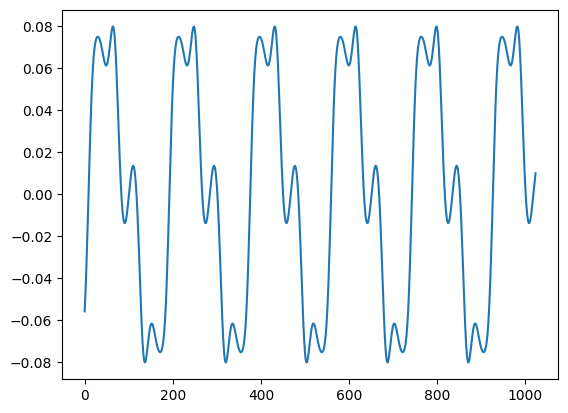

In [15]:
# prueba de instrumento

from instrument import *
import sounddevice as sd
import matplotlib.pyplot as plt
from tkinter import *

tk = Tk()
ins = Instrument(tk)
ins.amp = 1
ins.sustain=0.8

ins.noteOn(60)
signal = np.zeros(0)
for i in range(25):
    signal = np.concatenate((signal,ins.next()))

N = 1024
s = signal[-N:]

ins.noteOn(70)
signal2 = np.zeros(0)
for i in range(25):
    signal2 = np.concatenate((signal2,ins.next()))

#s = np.concatenate((s,signal2[:N]))

tot = np.concatenate((signal,signal2))
sd.play(tot)
sd.wait()

plt.plot(s)    



# Enrutado de señal

- Enrutamos la señal del instrumento a la entrada del stream de *sounddevice*

- El *callback* de sounddevice suma todas las entradas de la lista **inputs**

    - Visto de otro modo: todas las señales que queramos que suenen se incluyen en esta lista.

- En el callback se pide un **next()** de todas las entradas de **input**, se suman y se mandan al output

In [ ]:
from tkinter import *
import os
from instrument import *
import sounddevice as sd


def test():
    def callback(outdata, frames, time, status):    
        if status: print(status)    
        s = np.sum([i.next() for i in inputs],axis=0)
        s = np.float32(s)
        outdata[:] = s.reshape(-1, 1)

    tk = Tk()
    ins = Instrument(tk)
    inputs = [ins]

    # desactivar repeticion de teclas
    os.system('xset r off')

    stream = sd.OutputStream(samplerate=SRATE, channels=1, blocksize=CHUNK, callback=callback)    
    stream.start()
    tk.mainloop()

    # reactivar repeticion de teclas   
    os.system('xset r on')
    stream.close()

test()    


## Hebras de ejecución

En el ejemplo anterior tenemos 2 hebras que controlan la ejecución:

- *stream* está en modo *callback* escuchando/esperando señal en una hebra
    - Escucha todas las señales/generadores que hay en la lista *inputs*
    - Hace la mezcla de esas señales y las reproduce    
    - Todo esto lo hace por CHUNKs

- *tk.mainloop()* toma el control -> el control de ejecución está en la ventana de TkInter
    - Escucha eventos de los widgets (botones, sliders, etc)

*TkInter* tiene el control de ejecución... (será importante en breve)
  

# Secuenciador MIDI. De la notación simbólica a la interpretación

Vamos a procesar archivos MIDI: secuencia de eventos *noteOn/noteOff* con la nota y la duración de la misma (tiene más tipos de eventos, pero no nos interesan por ahora)

Utilizamos la librería *mido.py* para leer archivos midi.


In [ ]:
import mido

events = mido.MidiFile('narvaez.mid')

# todos los eventos
#for m in events: print(m)

# filtramos solo los noteOn/Off 
for m in events:    
    if m.type=='note_on':
        t = m.time
        # cuidado! hay midis que utilizan velocity=0 para el noteOff
        if m.velocity==0: print(f'{t:.4f} noteOff {m.note}  ch: {m.channel}')
        else: print(f'{t:.4f} noteOn  {m.note}  ch: {m.channel}  vel: {m.velocity} ')
    elif m.type=='note_off':
        print(f'{t:.4f} noteOff {m.note}  ch: {m.channel}')        

FileNotFoundError: [Errno 2] No such file or directory: 'narvaez.mid'

**Ojo**: los tiempos deltaTime representan tiempo transcurrido "desde el último evento*... pero es muy fácil ir llevando un acumulado para obtener el tiempo relativo al inicio de la reproducción de la secuencia.

- ver método *getSeq* abajo

## Enganchando *el bucle* de secuenciación

Problema: *TkInter* tiene el control de ejecución desde la llamada a *tk.mainloop()*

Para implementar el bucle de secuenciación **nos colamos en la hebra** de *TkInter* con el método *after*
    
- **after(time, func)**: después de *time* milisegundos llama a la función *func*

Haremos un método recursivo *playLoop(item,time)*

- *item* es el siguiente elemento de la secuencia que tocará procesar (primero de una cola)

- *time* es el tiempo transcurrido desde el inicio de la reproducción

- en cada llamada se actualiza *time* e *ítem*, si toca

- la llamada recursiva se deja programada con un *tick* de delay predefinido
    
    *after(tick, lambda: playLoop(item,time))*


In [16]:
%%writefile midiSequencerTk.py

import instrument
from tkinter import *
from consts import *
import sounddevice as sd
import numpy as np
import mido
import time 


class MidiSequencerTk:
    # análogo a lo anterior
    def __init__(self,tk,instrument=None):
        if instrument == None:            
            self.instrument = instrument.Instrument(tk,amp=0.2,ratio=3,beta=0.6)
        else:
            self.instrument = instrument

        frame = LabelFrame(tk, text="Midi Sequencer", bg="#908060")
        frame.pack(side=TOP)

        frameFile = Frame(frame, highlightbackground="blue", highlightthickness=6)
        frameFile.pack(side=TOP)
        Label(frameFile,text='Archivo MIDI: ').pack(side=LEFT)
 
        self.file = Entry(frameFile) #.pack(side=RIGHT)
        self.file.insert(14,"pirates.mid")
        self.file.pack(side=LEFT)

        self.transport = 0
        
        
        self.text = Text(frame,height=6,width=23)
        self.text.pack(side=RIGHT)
        playBut = Button(frame,text="Play", command=self.play)
        playBut.pack(side=TOP)
        stopBut = Button(frame,text="Stop", command=self.stop)
        stopBut.pack(side=BOTTOM)

        self.tick = 1
        self.state = 'off'
        
    # obtención de la secuencia midi (noteOn/Off) con tiempos relativos al inicio
    def getSeq(self,midiEvents):
        seq = []
        accTime = 0
        for m in midiEvents:
            accTime += m.time
            if m.type=='note_on':
                if m.velocity==0: seq.append((accTime,'noteOff',m.note+self.transport,m.channel))
                else: seq.append((accTime,'noteOn',m.note+self.transport,m.channel))    
            elif m.type=='note_off':
                seq.append((accTime,'noteOff',m.note+self.transport,m.channel))
        return seq

  
    def play(self):
        events = mido.MidiFile(self.file.get())
        seq = self.getSeq(events)
        print(seq)

        self.state = 'on'
        self.playLoop(seq)

    def playLoop(self,seq,item=0,accTime=0):   
        if item>=len(seq) or self.state =='off':
            return

        # ahora tenemos que procesar todos los ítems cuyo tiempo supere el crono accTime    
        while item<len(seq) and accTime>=seq[item][0]:
            (_,msg,midiNote,_chan) = seq[item]  # (time,'noteOff',midNote,channel)
            self.text.insert('6.0',  f'{msg} {midiNote}\n') 
            if msg=='noteOn':  
                self.instrument.noteOn(midiNote)                   
            else: # msg noteOff    
                self.instrument.noteOff(midiNote)                   
            item += 1 # y avanzmos ítem


        # avanzammos crono 
        accTime += self.tick/1000

        self.text.after(self.tick,lambda: self.playLoop(seq,item,accTime)) 

         
    def stop(self):
        self.instrument.stop()
        self.state = 'off'   


Writing midiSequencerTk.py


In [17]:
%load_ext autoreload
%autoreload 2

from midiSequencerTk import *
import os    
from instrument import *


def test():
    def callback(outdata, frames, time, status):    
        if status: print(status)    
        #print(inputs)
        s = np.sum([i.next() for i in inputs],axis=0)
        s = np.float32(s)
        outdata[:] = s.reshape(-1, 1)

    os.system('xset r off')
    tk = Tk()
    ins = Instrument(tk)

    seq = MidiSequencerTk(tk,ins)
    #print(seq.seq)
    inputs = [ins]

    stream = sd.OutputStream(samplerate=SRATE, channels=1, blocksize=CHUNK, callback=callback)
    stream.start()

    tk.mainloop()

    stream.close()
    os.system('xset r on')

test()



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
noteOn 48
noteOff 48
noteOn 50
noteOff 50
noteOn 50
noteOff 50


# Arquitectura

![dibujo.png](dibujo.png)

# Inserciones (de efectos)

Podemos insertar un efecto "interceptando" cualquier envío de señal de un generador (líneas rosas)

- El efecto toma la señal de entrada del generador con **next()**

- Y devuelve la señal transformada implementado un **next()**

Vamos probar con un filtro IIR sencillo. 

- Incluimos la frecuencia de corte como parámetro en un Slider


In [18]:
%%writefile lpFilter.py

from consts import *
import numpy as np
from tkinter import *
from slider import *
#from controller import *

class LPfilter:
    def __init__(self,tk,signal=None,freq=10000):        
        # señal de entrada
        self.signal = signal

        self.memo = 0.0
        frame = LabelFrame(tk, text="LP Filter", bg="#908060")
        frame.pack(side=TOP)

        self.freqS = Slider(frame,'freq',packSide=TOP,
                           ini=freq,from_=50,to=20000,step=100) 
        
    def next(self):    
        print('entro')  
        # calculo de alpha en función de la frecuencia de corte       
        alpha = np.exp(-2*np.pi*self.freqS.get() / SRATE)       

        # chunk de entrada pedido next() al generador 
        bloque= self.signal.next()
        bloque[0] = alpha * self.memo + (1-alpha) * bloque[0]
        for i in range(1,CHUNK):         
            bloque[i] = alpha * bloque[i-1] + (1-alpha) * bloque[i]            
        
        self.memo = bloque[CHUNK-1]
        return bloque


Writing lpFilter.py


Vamos a conectar el filtro a la salida del instrumento:
- Probar con distintas frecuencias de corte utilizando el teclado 
- Probar con el secuencidor midi

In [19]:
%load_ext autoreload
%autoreload 2

from consts import *
from midiSequencerTk import *
import os    
from instrument import *
from lpFilter import *

def test():
    def callback(outdata, frames, time, status):    
        if status: print(status)    
        #print(inputs)
        s = np.sum([i.next() for i in inputs],axis=0)
        s = np.float32(s)
        outdata[:] = s.reshape(-1, 1)

    os.system('xset r off')
    tk = Tk()

    ins = Instrument(tk)
    seq = MidiSequencerTk(tk,instrument=ins)
    filter = LPfilter(tk,ins)      
    inputs = [filter]

   

    stream = sd.OutputStream(samplerate=SRATE, channels=1, blocksize=CHUNK, callback=callback)
    stream.start()

    tk.mainloop()

    stream.close()

    os.system('xset r on')


test()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro


# Añadiendo efectos con librería externa: PedalBoard

...

In [20]:
%%writefile reverb.py

from consts import *
from pedalboard import Pedalboard, Compressor, Reverb
from slider import *


class MiReverb:
    def __init__(self,tk,signal):
        self.signal = signal
        frame = LabelFrame(tk, text="PB Reverb", bg="#808090")
        frame.pack(side=BOTTOM)
        
        self.wetlS = Slider(frame,'WetLevel',packSide=TOP,
                           ini=0.0,from_=0.0,to=1.0,step=0.05) 
        
        self.board = Pedalboard([Reverb()])
        self.rev = self.board[0]
        self.rev.wet_level = .3

    def next(self):
        chunk = self.signal.next()
        self.rev.wet_level = self.wetlS.get()
        #print(self.rev.wet_level)
        chunk = self.board.process(chunk,sample_rate=SRATE, reset=False)
        return chunk


Overwriting reverb.py


In [24]:
%%writefile effects.py

from consts import *
from pedalboard import Pedalboard, Compressor, Reverb, Gain, Chorus, LadderFilter, Phaser
from slider import *


class Effects:
    def __init__(self,tk,signal):
        self.signal = signal
        frame = LabelFrame(tk, text="PB Reverb", bg="#808090")
        frame.pack(side=BOTTOM)
        
        self.wetlS = Slider(frame,'WetLevel',packSide=TOP,                          ini=0.0,from_=0.0,to=1.0,step=0.05) 
        
        self.board = Pedalboard([
            Compressor(threshold_db=-50, ratio=25),
            Gain(gain_db=30),
            Chorus(),
            LadderFilter(mode=LadderFilter.Mode.HPF12, cutoff_hz=900),
            Phaser(),
            #Convolution("./guitar_amp.wav", 1.0),
            Reverb(room_size=0.25),
        ])


    def next(self):
        chunk = self.signal.next()
        #self.rev.wet_level = self.wetlS.get()
        #print(self.rev.wet_level)
        chunk = self.board.process(chunk,sample_rate=SRATE, reset=False)
        return chunk

Overwriting effects.py


In [25]:
from midiSequencerTk import *
import os    
from instrument import *
import effects


def test():
    def callback(outdata, frames, time, status):    
        if status: print(status)    
        #print(inputs)
        s = np.sum([i.next() for i in inputs],axis=0)
        s = np.float32(s)
        outdata[:] = s.reshape(-1, 1)

    os.system('xset r off')
    tk = Tk()
    ins = Instrument(tk)
    seq = MidiSequencerTk(tk,instrument=ins)
    
    #insRev = reverb.MiReverb(tk,ins)      
    # inputs = [insRev]
    
    insRev = effects.Effects(tk,ins)          
    inputs = [insRev]

    stream = sd.OutputStream(samplerate=SRATE, channels=1, blocksize=CHUNK, callback=callback)
    stream.start()

    tk.mainloop()

    stream.close()

    os.system('xset r on')


test()
